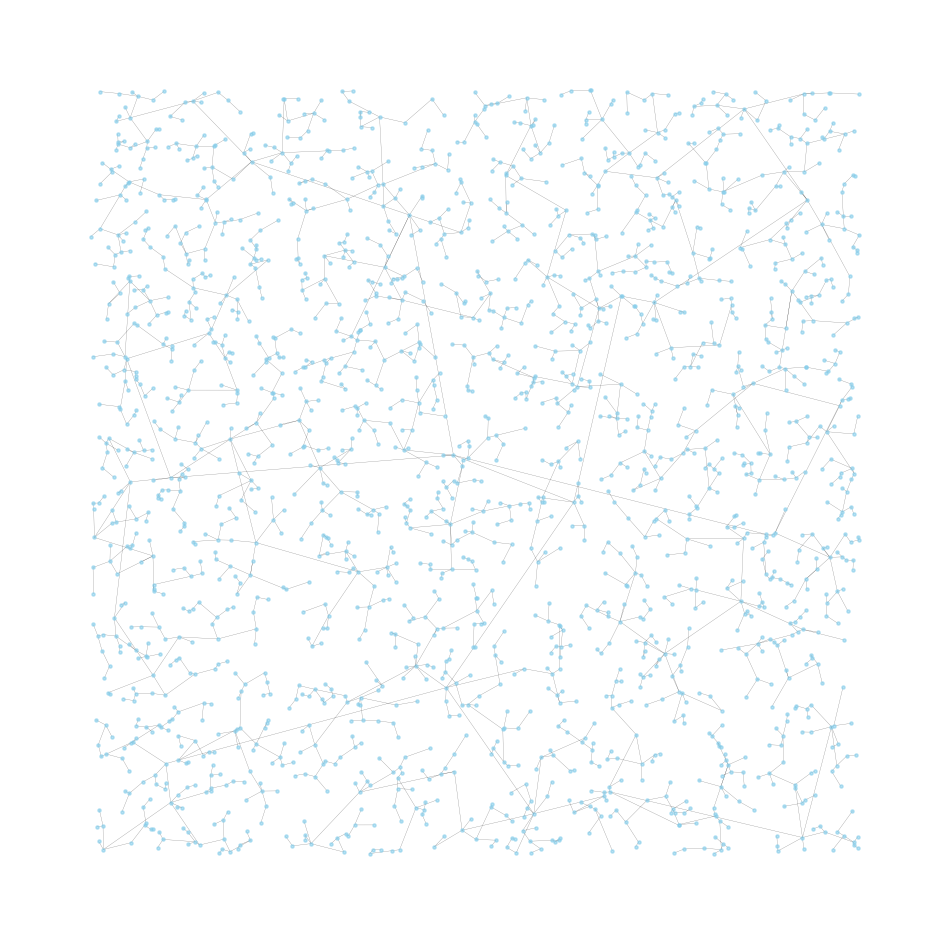

True
Number of nodes: 2000


In [26]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def generate_node_features(num_nodes):
    node_features = {}
    scale = np.sqrt(num_nodes)  # scaling factor based on number of nodes
    for i in range(num_nodes):
        position = (np.random.uniform(0, 100 * scale), np.random.uniform(0, 100 * scale))
        node_features[i] = {
            'position': position,
            'transmission_power': np.random.normal(loc=25, scale=10),
            'battery': np.random.beta(5, 2),
            'bandwidth_usage': np.random.uniform(0, 80),
            'cpu': np.random.beta(2, 5),
            'ram': np.random.beta(2, 4),
            'temperature': np.random.normal(loc=20, scale=10),
            'location': np.random.choice(['urban', 'rural'])
        }
    return node_features

def compute_distance(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def generate_graph(node_features):
    G = nx.Graph()

    for node, features in node_features.items():
        G.add_node(node, **features)

    for i in G.nodes():
        for j in G.nodes():
            if i != j:
                distance = compute_distance(G.nodes[i]['position'], G.nodes[j]['position'])
                if distance < 40:
                    latency = np.random.uniform(10, 100)
                    snr = np.random.uniform(30, 70)
                    link_bandwidth = np.random.normal(loc=110, scale=20)
                    if latency < 70 and snr > 40 and link_bandwidth > G.nodes[i]['bandwidth_usage']:
                        G.add_edge(i, j, latency=latency, snr=snr, bandwidth=link_bandwidth)

    # Ensure the graph is fully connected
    while not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        for node in G:
            if node not in largest_cc:
                distances = [(neighbor, compute_distance(G.nodes[node]['position'], G.nodes[neighbor]['position'])) for neighbor in largest_cc]
                closest_node = min(distances, key=lambda x: x[1])[0]
                G.add_edge(node, closest_node)
                break  # exit and recompute the largest_cc

    return G

def visualize_graph(G):
    positions = nx.get_node_attributes(G, 'position')

    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, positions, node_color='skyblue', node_size=5, alpha=0.6)
    nx.draw_networkx_edges(G, positions, width=0.2, alpha=0.5)

    plt.axis('off')
    plt.show()

node_features = generate_node_features(num_nodes=2000)
G = generate_graph(node_features)
visualize_graph(G)


# Check if the graph G is fully connected
is_fully_connected = nx.is_connected(G)

print(is_fully_connected)  # This will return True if the graph is fully connected, otherwise False
print("Number of nodes:", G.number_of_nodes())


In [ ]:
!pip install torch_geometric

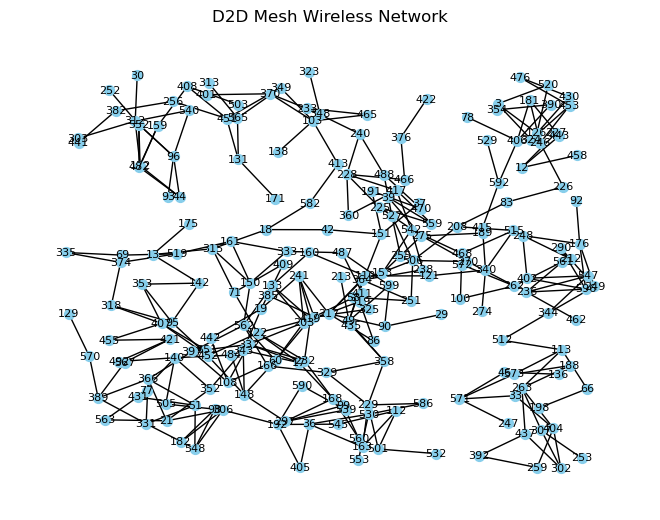

Number of nodes after discarding isolated nodes and keeping largest subgraph: 219


In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Global Variables
network_size = (100, 100)  # Size of the 2D space in meters
num_nodes = 600 # Initial number of nodes

# Create a D2D mesh wireless network
G = nx.Graph()

# Add nodes with features
for i in range(num_nodes):
    position = (np.random.uniform(0, network_size[0]), np.random.uniform(0, network_size[1]))
    battery = np.random.uniform(0.1, 1) 
    cpu = np.random.uniform(0.1, 1)
    memory = np.random.uniform(0.1, 1)
    bandwidth = np.random.uniform(10, 100) #MHz
    transmission_power = np.random.uniform(0.9, 1.2) # normally ~1mW

    G.add_node(i, 
               position=position, 
               battery=battery, 
               cpu=cpu, 
               memory=memory, 
               bandwidth=bandwidth, 
               transmission_power=transmission_power)

# Implement edge creation criteria
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 < node2:  # Avoid duplicate edges and self-loops
            dist = np.sqrt((G.nodes[node1]['position'][0] - G.nodes[node2]['position'][0])**2 + 
                           (G.nodes[node1]['position'][1] - G.nodes[node2]['position'][1])**2)
            signal_strength = G.nodes[node1]['transmission_power'] / (dist**2)
            if 10 < dist < 50 and signal_strength > 0.008 and G.degree[node1] < 5 and G.degree[node2] < 5 and \
                    all(G.nodes[node]['battery'] > 0.3 for node in (node1, node2)) and \
                    all(G.nodes[node]['cpu'] < 0.8 for node in (node1, node2)) and \
                    all(G.nodes[node]['memory'] < 0.8 for node in (node1, node2)):
                G.add_edge(node1, node2)

# Discard nodes without neighbors
isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

# Keep only the largest subgraph
largest_subgraph_nodes = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_subgraph_nodes)


# Plot the graph based on position_x and position_y
pos = {node: G.nodes[node]['position'] for node in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=50, node_color='skyblue', font_size=8)
plt.title("D2D Mesh Wireless Network")
plt.show()

# Print the resulting number of nodes
print(f"Number of nodes after discarding isolated nodes and keeping largest subgraph: {G.number_of_nodes()}")